# Learning geometry of geodesics

This is the work done with Samuel Gruffaz on using RKHS to learn the shape of the geodesics.

In [1]:
import numpy as np
import pandas as pd
import torch
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm

import sys, os
import cvxpy as cp

os.chdir("/Users/samuel.gruffaz/Documents/PEcollab")
sys.path.append("/Users/samuel.gruffaz/Documents/PEcollab")
from leaspy.api import Leaspy

from leaspy import Leaspy, Data, AlgorithmSettings, Plotter, Dataset, IndividualParameters
from leaspy.models.utils.attributes.attributes_factory import AttributesFactory
from leaspy.algo.algo_factory import AlgoFactory


from leaspy.models.utils.OptimB import *

In [2]:
def generate_data(model, n_individuals, nb_visits_min, nb_visits_mean, window):
    # Sampling individuals :

    N = n_individuals

    individuals = []

    data = [[], []] + [[] for k in range(model.dimension)]

    for i in range(N):
        tau = np.random.normal(loc=model.parameters['tau_mean'], scale=model.parameters['tau_std'])
        xi = np.random.normal(loc=model.parameters['xi_mean'], scale=model.parameters['xi_std'])
        n_tpts = nb_visits_min + np.random.binomial(2 * (nb_visits_mean-nb_visits_min),0.5)
        tpts = np.sort((np.random.normal(0., 1., size=(n_tpts)) * window) + tau)
        timepoints = torch.tensor(tpts, dtype=float)
        sources = None
        if model.source_dimension is not None:
            sources = np.random.normal(loc=model.parameters['sources_mean'], scale=model.parameters['sources_std'], size=(model.source_dimension))
            values = model.compute_individual_tensorized(timepoints, {"tau":torch.tensor(tau), "xi":torch.tensor(xi), "sources":torch.Tensor(sources)}).detach().numpy()
        else:   
            values = model.compute_individual_tensorized(timepoints, {"tau":torch.tensor(tau), "xi":torch.tensor(xi)}).detach().numpy()
        values = values + np.random.normal(0., model.parameters['noise_std'], size=(n_tpts, model.dimension))
        individuals.append({"idx":i+1, "tau":tau, "xi":xi, "tpts":tpts, "sources":sources, "values":values})
        data[0] += [i+1] * n_tpts
        data[1] += list(tpts)
        for k in range(model.dimension):
            data[2+k] += list(values[0, :, k])
    data = np.array(data).T
    df = pd.DataFrame(data, columns=['ID', 'TIME']+["Y"+str(k+1) for k in range(model.dimension)])
    df.set_index(['ID', 'TIME'], inplace=True)
    return df, individuals

def plot_generative(ax, individuals, model1, nb_ind_plot, dimension):

    for i in range(nb_ind_plot):
        params = individuals[i]
        mean_par = {key:torch.tensor(params[key])for key in ["tau", "xi"]}
        mean_par["sources"] = torch.Tensor(params["sources"])
        t = torch.tensor(np.linspace(np.min(params["tpts"])-1.,np.max(params["tpts"])+1.,100), dtype=torch.float)

        trajectory = model1.compute_individual_tensorized(t, mean_par).squeeze(0)
        for j in range(dimension):
            ax[i,j].plot(individuals[i]['tpts'], individuals[i]['values'][0,:,j], "o")
            ax[i,j].plot(t, trajectory[..., j])

def plot_fit(ax, results, model, individuals, nb_ind_plot, dimension):

    for i in range(nb_ind_plot):
        params = results._individual_parameters[results._indices[i]]
        params["tpts"] = individuals[i]["tpts"]
        mean_par = {key:torch.tensor(params[key])for key in ["tau", "xi"]}
        mean_par["sources"] = torch.Tensor(params["sources"])
        t = torch.tensor(np.linspace(np.min(params["tpts"])-1.,np.max(params["tpts"])+1.,100), dtype=torch.float)

        trajectory = model.compute_individual_tensorized(t, mean_par).squeeze(0)
        for j in range(dimension):
            ax[i,j].plot(t, trajectory[..., j])

In [3]:
leaspy = Leaspy('linearB')
dimension = 2
sources_dimension = 1
leaspy.model.parameters = {'g': [0., 1.],
                           'v0':[.5, 0.],
                           'betas':[[1.]],
                           'tau_mean': 70., 'tau_std': 5.,
                           'xi_mean': 0., 'xi_std': .1,
                           'sources_mean': 0.,
                           'sources_std': 1.,
                           'noise_std': [.1]}
model1 = leaspy.model
model1.dimension = dimension
model1.source_dimension = sources_dimension
model1.parameters = {key: torch.tensor(val) for key, val in model1.parameters.items()}
model1.attributes = AttributesFactory.attributes(model1.name, dimension, sources_dimension)
model1.attributes._compute_positions(model1.parameters)
model1.attributes._compute_velocities(model1.parameters)
model1.attributes._compute_betas(model1.parameters)
model1.attributes._compute_orthonormal_basis()
model1.attributes._compute_mixing_matrix()
model1.is_initialized = True

periode = 15.
amplitude = 2.
model1.B = lambda x : x + amplitude * torch.cos(x * 2 * np.pi/periode)

In [4]:
n_individuals = 100
nb_visits_min = 2
nb_visits_mean = 6
window = 10.

data, individuals = generate_data(model1, n_individuals, nb_visits_min, nb_visits_mean, window)

leaspy_data = Data.from_dataframe(data)

In [16]:
dataset=Dataset(leaspy_data)
mask=dataset.mask
print(mask.reshape())
print(dataset.values[mask.bool()])

tensor([-17.7311, -10.2214,  -5.7261,  ...,   4.0185,  23.7178,  17.7929])


In [68]:
import scipy.linalg as LA




def optim_solver(X, Y, K, indices, dim, sigma):
    W = cp.Variable((K.shape[1], dim))
    K_ = cp.Parameter((K.shape[1], K.shape[1]), PSD=True)
    K_.value = K[indices].detach().numpy()
    X_ = X.detach().numpy()
    Y_ = Y.detach().numpy()

    constraints = [cp.atoms.sum([cp.atoms.quad_form(W[:,k], K_) for k in range(dim)]) <= sigma**2/dim]
    prob = cp.Problem(cp.Minimize(cp.atoms.norm(Y - (X + K.detach().numpy()@W),"fro")), constraints)
    
    prob.solve()
    
    return W.value


def outer_iteration(leaspy_test, leaspy_data, dataset, meta_settings):
    
    fit_settings = meta_settings["fit"]
    leaspy_test.fit(leaspy_data, algorithm_settings=fit_settings)

    perso_settings = meta_settings["personalize"]
    results = leaspy_test.personalize(leaspy_data, perso_settings)
    _, ind_params = results.to_pytorch()
    
    X = leaspy_test.model.compute_individual_tensorized_linear(dataset.timepoints, ind_params)
    Y = dataset.values

    X_acc = []
    Y_acc = []

    for i in range(X.shape[0]):
        X_acc.append(X[i, :dataset.nb_observations_per_individuals[i]])
        Y_acc.append(Y[i, :dataset.nb_observations_per_individuals[i]])    

    X = torch.cat(X_acc)
    Y = torch.cat(Y_acc)
    
    indices = sub_sampling(X, meta_settings["nb_control_points"],select=meta_settings["select"])
    X_control = X[indices]
    
    K = compute_kernel_matrix(X, meta_settings, X_control)
    
    W_opt = optim_solver(X, Y, K, indices, leaspy_test.model.dimension, meta_settings["sigma"])
    
    leaspy_test.model.B = transformation_B(X_control, W_opt, meta_settings)
    return results

In [69]:
def outer_iteration2(leaspy_test, leaspy_data, dataset, meta_settings):
    
    fit_settings = meta_settings["fit"]
    leaspy_test.fit(leaspy_data, algorithm_settings=fit_settings)

    perso_settings = meta_settings["personalize"]
    results = leaspy_test.personalize(leaspy_data, perso_settings)
    _, ind_params = results.to_pytorch()
    
    X = leaspy_test.model.compute_individual_tensorized(dataset.timepoints, ind_params)
    Y = dataset.values

    X_acc = []
    Y_acc = []

    for i in range(X.shape[0]):
        X_acc.append(X[i, :dataset.nb_observations_per_individuals[i]])
        Y_acc.append(Y[i, :dataset.nb_observations_per_individuals[i]])    

    X = torch.cat(X_acc)
    Y = torch.cat(Y_acc)
    
    indices = sub_sampling(X, meta_settings["nb_control_points"],select=meta_settings["select"])
    X_control = X[indices]
    
    K = compute_kernel_matrix(X, meta_settings, X_control)
    
    W_opt = optim_solver(X, Y, K, indices, leaspy_test.model.dimension, meta_settings["sigma"])

    oldB=leaspy_test.model.B 
    
    leaspy_test.model.B = transformation_B_compose(X_control, W_opt, meta_settings,oldB)
    return results

In [70]:
import time
import scipy.linalg as LA
def optim_solver2(X, Y, K, indices, dim, sigma):
    t1=time.clock()
    KCC = K[indices].detach().numpy()
    KG=K.detach().numpy()

    Kred=KG.transpose()@KG
    
    X_ = X.detach().numpy()
    Y_ = Y.detach().numpy()

    Const=Y_-X_
    DD=KG.transpose()@Const
    lambd=1
    lambdmin=1
    Mat=lambd*KCC+Kred
    
    w,V=LA.eigh(Mat)
    delta = np.abs(Mat - (V * w).dot(V.T))
    print("erreur projection")
    print(LA.norm(delta, ord=2))

    W=np.linalg.solve(Mat,DD)

    contrainte=sigma**2/dim


    g=lambda w: np.trace(w.transpose()@KCC@w)

    while g(W)>contrainte:
        print(lambd)
        lambd,lambdmin=lambd*2,lambd
        Mat=lambd*KCC+Kred
        W=np.linalg.solve(Mat,DD)
    #rajouter ensuite une recherche dicotomique du lambda optimal
    f=lambda l: np.trace(np.linalg.solve(l*KCC+Kred,DD).transpose()@KCC@np.linalg.solve(l*KCC+Kred,DD))
    lopt=dicho(lambdmin,lambd,contrainte,f)
    Mat=lopt*KCC+Kred
    W=np.linalg.solve(Mat,DD)
    t2=time.clock()
    print("temps opti quadra")
    print(t2-t1)
    return W

In [54]:
def dicho(a,b,c,f,err=10**(-2)):
    mi=a
    ma=b
    pivot=(mi+ma)/2
    dec=abs(f(pivot)-c)
    k=0
    while dec>err and k<20:
        k=k+1
        comp=f(pivot)
        if comp>c:
            mi=pivot
        else:
            ma=pivot
        pivot=(mi+ma)/2
        dec=abs(f(pivot)-c)
    return pivot
        

In [52]:
f=lambda x:-x

print(dicho(1,2,-1.2,f))

1.203125


In [71]:
def outer_iteration3(leaspy_test, leaspy_data, dataset, meta_settings):
    
    fit_settings = meta_settings["fit"]
    leaspy_test.fit(leaspy_data, algorithm_settings=fit_settings)

    perso_settings = meta_settings["personalize"]
    results = leaspy_test.personalize(leaspy_data, perso_settings)
    _, ind_params = results.to_pytorch()
    
    X = leaspy_test.model.compute_individual_tensorized(dataset.timepoints, ind_params)
    Y = dataset.values

    X_acc = []
    Y_acc = []

    for i in range(X.shape[0]):
        X_acc.append(X[i, :dataset.nb_observations_per_individuals[i]])
        Y_acc.append(Y[i, :dataset.nb_observations_per_individuals[i]])    

    X = torch.cat(X_acc)
    Y = torch.cat(Y_acc)
    
    indices = sub_sampling(X, meta_settings["nb_control_points"],select=meta_settings["select"])
    X_control = X[indices]
    
    K = compute_kernel_matrix(X, meta_settings, X_control)
    
    W_opt = optim_solver2(X, Y, K, indices, leaspy_test.model.dimension, meta_settings["sigma"])

    oldB=leaspy_test.model.B 
    
    leaspy_test.model.B = transformation_B_compose(X_control, W_opt, meta_settings,oldB)
    return results


The standard deviation of the noise at the end of the calibration is:
1.4286

Calibration took: 5s

The standard deviation of the noise at the end of the personalization is:
1.2460

Personalization scipy_minimize took: 7s
1
2
4
8
16
temps opti quadra
0.029954000000088854
ipykernel_launcher:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
ipykernel_launcher:35: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead

The standard deviation of the noise at the end of the calibration is:
0.8786

Calibration took: 6min 15s

The standard deviation of the noise at the end of the personalization is:
0.7599

Personalization scipy_minimize took: 13s
1
2
4
temps opti quadra
0.051675000000159343
ipykernel_launcher:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be re

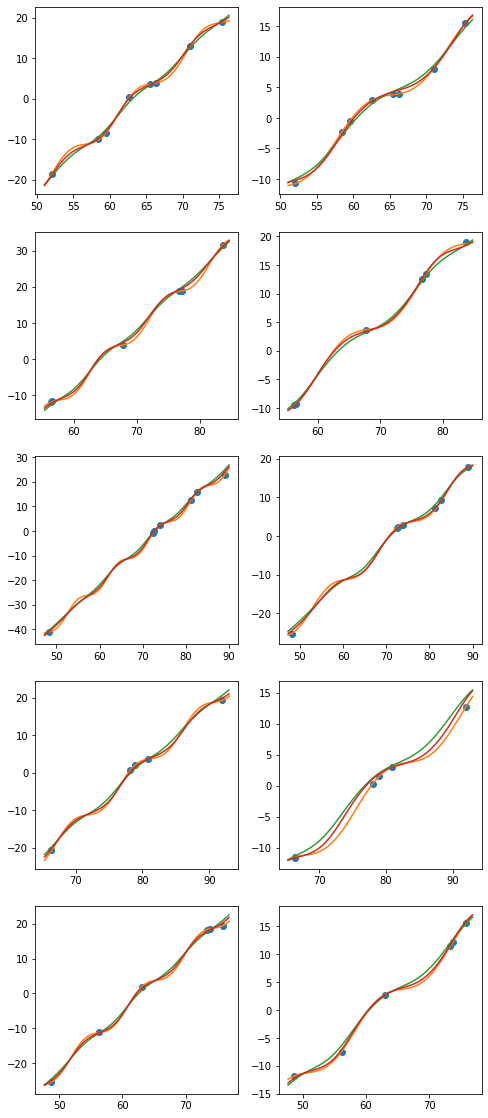

In [60]:
leaspy_test = Leaspy('linearB')

leaspy_test.model.load_hyperparameters({'source_dimension': 1}) # Optional
dataset = Dataset(leaspy_data)

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 5., 
                 "nb_control_points" : 100,"select":0.01}
meta_settings["fit"] = AlgorithmSettings('mcmc_saem', n_iter=1000, loss='MSE')
meta_settings["personalize"] = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_generative(ax, individuals, model1, nb_ind_plot, dimension)

for k in range(2):
    results = outer_iteration3(leaspy_test, leaspy_data, dataset, meta_settings)
    plot_fit(ax, results, leaspy_test.model, individuals, nb_ind_plot, dimension)
    
plt.show()

Le solver faitmain fonctionne bien en temps raisonable. 


The standard deviation of the noise at the end of the calibration is:
1.4156

Calibration took: 6s

The standard deviation of the noise at the end of the personalization is:
1.2573

Personalization scipy_minimize took: 7s
ipykernel_launcher:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
ipykernel_launcher:41: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
erreur projection
0.006194154
1
2
4
8
16
temps opti quadra
0.11859800000001997

The standard deviation of the noise at the end of the calibration is:
0.8609

Calibration took: 12min 18s

The standard deviation of the noise at the end of the personalization is:
0.7593

Personalization scipy_minimize took: 15s
ipykernel_launcher:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Pyth

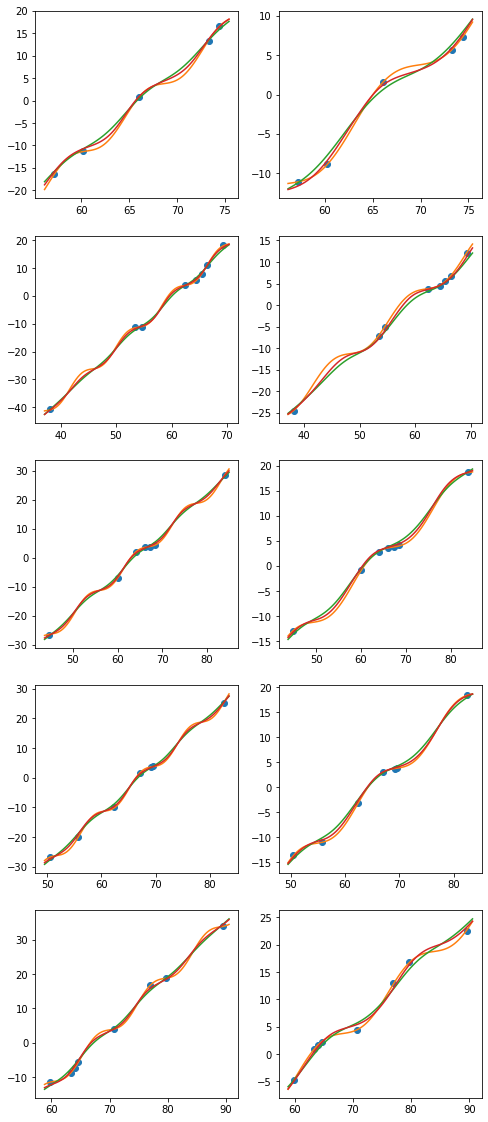

In [74]:
leaspy_test = Leaspy('linearB')

leaspy_test.model.load_hyperparameters({'source_dimension': 1}) # Optional
dataset = Dataset(leaspy_data)

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 5., 
                 "nb_control_points" : 200,"select":0.01}
meta_settings["fit"] = AlgorithmSettings('mcmc_saem', n_iter=1000, loss='MSE')
meta_settings["personalize"] = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_generative(ax, individuals, model1, nb_ind_plot, dimension)

for k in range(2):
    results = outer_iteration3(leaspy_test, leaspy_data, dataset, meta_settings)
    plot_fit(ax, results, leaspy_test.model, individuals, nb_ind_plot, dimension)
    
plt.show()


The standard deviation of the noise at the end of the calibration is:
1.4292

Calibration took: 5s

The standard deviation of the noise at the end of the personalization is:
1.2745

Personalization scipy_minimize took: 7s
/opt/anaconda3/envs/leaspy/lib/python3.7/site-packages/cvxpy/reductions/solvers/solving_chain.py:164: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)

The standard deviation of the noise at the end of the calibration is:
0.8696

Calibration took: 3min 13s

The standard deviation of the noise at the end of the personalization is:
0.7615

Personalization scipy_minimize took: 12s
/opt/anaconda3/envs/leaspy/lib/python3.7/site-packages/cvxpy/reductions/solvers

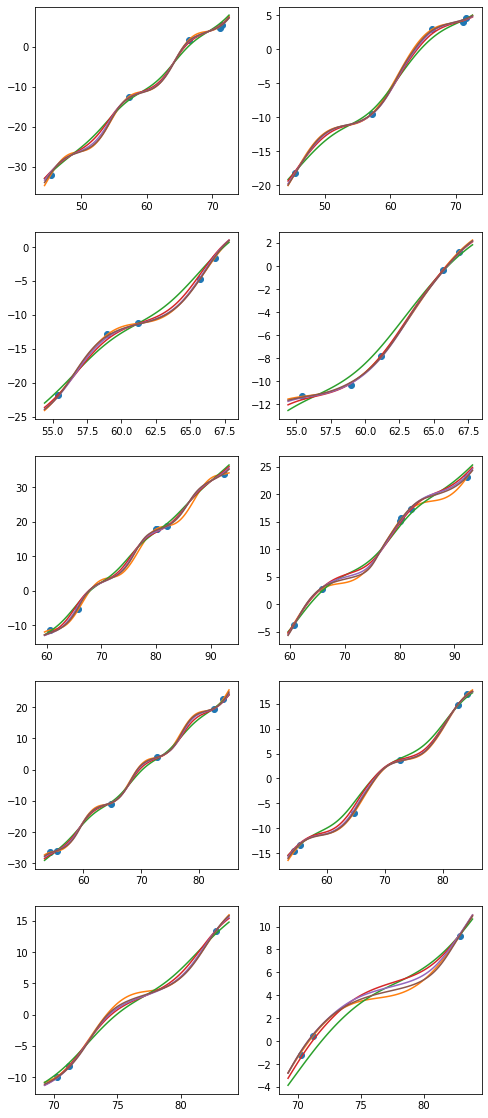

In [18]:
leaspy_test = Leaspy('linearB')

leaspy_test.model.load_hyperparameters({'source_dimension': 1}) # Optional
dataset = Dataset(leaspy_data)

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 5., 
                 "nb_control_points" : 50,"select":0.01}
meta_settings["fit"] = AlgorithmSettings('mcmc_saem', n_iter=1000, loss='MSE')
meta_settings["personalize"] = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_generative(ax, individuals, model1, nb_ind_plot, dimension)

for k in range(4):
    results = outer_iteration2(leaspy_test, leaspy_data, dataset, meta_settings)
    plot_fit(ax, results, leaspy_test.model, individuals, nb_ind_plot, dimension)
    
plt.show()

In [34]:
W_opt = W.value
leaspy_test.model.B = transformation_B(X_control, W_opt, meta_settings)

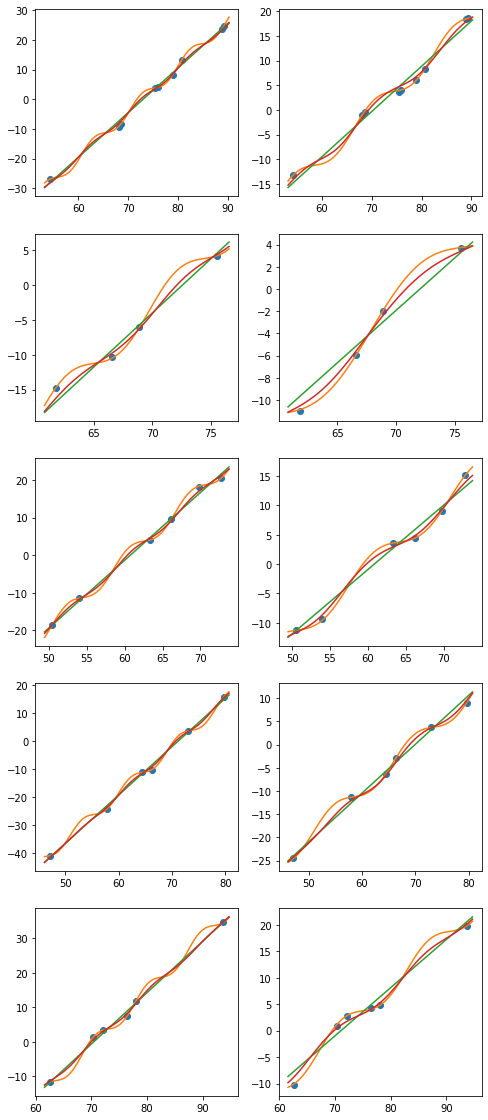

In [35]:
fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_generative(ax, individuals, model1, nb_ind_plot, dimension)
leaspy_test.model.B = lambda x: x 
plot_fit(ax, results, leaspy_test.model, individuals, nb_ind_plot, dimension)
leaspy_test.model.B = transformation_B(X_control, W_opt, meta_settings)
plot_fit(ax, results, leaspy_test.model, individuals, nb_ind_plot, dimension)
plt.show()


The standard deviation of the noise at the end of the calibration is:
1.4309

Calibration took: 11s

The standard deviation of the noise at the end of the personalization is:
1.2733

Personalization scipy_minimize took: 10s


/Users/p-e.poulet/opt/miniconda2/envs/aramis/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:164: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)



The standard deviation of the noise at the end of the calibration is:
1.0467

Calibration took: 1min 2s

The standard deviation of the noise at the end of the personalization is:
0.9214

Personalization scipy_minimize took: 17s


/Users/p-e.poulet/opt/miniconda2/envs/aramis/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:164: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)



The standard deviation of the noise at the end of the calibration is:
1.0288

Calibration took: 59s

The standard deviation of the noise at the end of the personalization is:
0.9075

Personalization scipy_minimize took: 20s


/Users/p-e.poulet/opt/miniconda2/envs/aramis/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:164: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


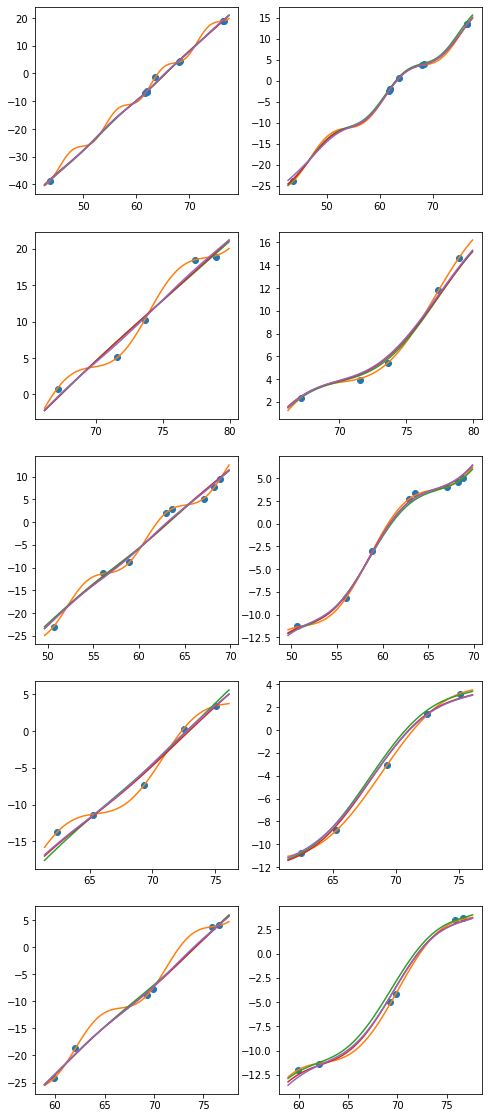

In [29]:
leaspy_test = Leaspy('linearB')

leaspy_test.model.load_hyperparameters({'source_dimension': 1}) # Optional
dataset = Dataset(leaspy_data)

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 10., 
                 "nb_control_points" : 10}
meta_settings["fit"] = AlgorithmSettings('mcmc_saem', n_iter=1000, loss='MSE')
meta_settings["personalize"] = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_generative(ax, individuals, model1, nb_ind_plot, dimension)

for k in range(3):
    results = outer_iteration(leaspy_test, leaspy_data, dataset, meta_settings)
    plot_fit(ax, results, leaspy_test.model, individuals, nb_ind_plot, dimension)
    
plt.show()

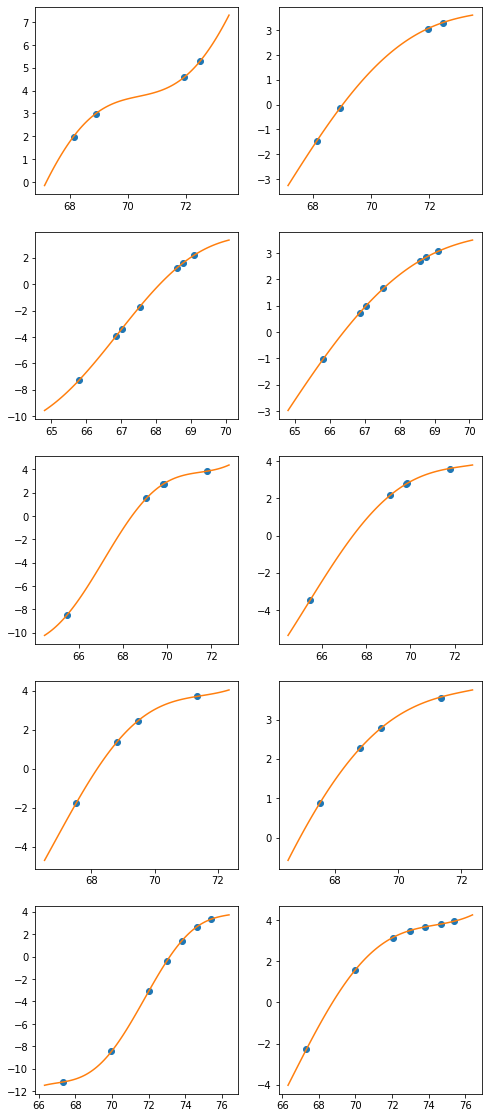

In [19]:
leaspy = Leaspy('linearB')
dimension = 2
sources_dimension = 1
leaspy.model.parameters = {'g': [0., 1.],
                           'v0':[.5, 0.],
                           'betas':[[1.]],
                           'tau_mean': 70., 'tau_std': 5.,
                           'xi_mean': 0., 'xi_std': .1,
                           'sources_mean': 0.,
                           'sources_std': 1.,
                           'noise_std': [.01]}
model1 = leaspy.model
model1.dimension = dimension
model1.source_dimension = sources_dimension
model1.parameters = {key: torch.tensor(val) for key, val in model1.parameters.items()}
model1.attributes = AttributesFactory.attributes(model1.name, dimension, sources_dimension)
model1.attributes._compute_positions(model1.parameters)
model1.attributes._compute_velocities(model1.parameters)
model1.attributes._compute_betas(model1.parameters)
model1.attributes._compute_orthonormal_basis()
model1.attributes._compute_mixing_matrix()
model1.is_initialized = True

periode = 15.
amplitude = 2.
model1.B = lambda x : x + amplitude * torch.cos(x * 2 * np.pi/periode)

n_individuals = 100
nb_visits_min = 2
nb_visits_mean = 6
window = 2.

data, individuals = generate_data(model1, n_individuals, nb_visits_min, nb_visits_mean, window)

leaspy_data = Data.from_dataframe(data)

nb_ind_plot = 5

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(dimension * 4, nb_ind_plot * 4))

plot_generative(ax, individuals, model1, nb_ind_plot, dimension)
plt.show()


The standard deviation of the noise at the end of the calibration is:
0.8063

Calibration took: 5s

The standard deviation of the noise at the end of the personalization is:
0.7111

Personalization scipy_minimize took: 8s
/opt/anaconda3/envs/leaspy/lib/python3.7/site-packages/cvxpy/reductions/solvers/solving_chain.py:164: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)

The standard deviation of the noise at the end of the calibration is:
0.4480

Calibration took: 47s

The standard deviation of the noise at the end of the personalization is:
0.3925

Personalization scipy_minimize took: 14s
/opt/anaconda3/envs/leaspy/lib/python3.7/site-packages/cvxpy/reductions/solvers/solv

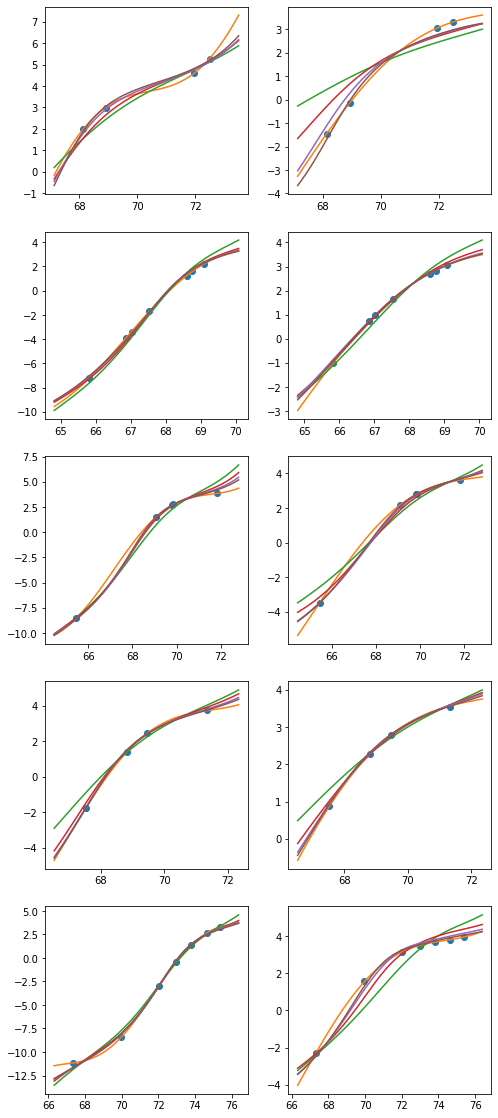

In [20]:
leaspy_test = Leaspy('linearB')

leaspy_test.model.load_hyperparameters({'source_dimension': 1}) # Optional
dataset = Dataset(leaspy_data)

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 5, 
                 "nb_control_points" : 10,"select":0.01}
meta_settings["fit"] = AlgorithmSettings('mcmc_saem', n_iter=1000, loss='MSE')
meta_settings["personalize"] = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_generative(ax, individuals, model1, nb_ind_plot, dimension)

for k in range(4):
    results = outer_iteration2(leaspy_test, leaspy_data, dataset, meta_settings)
    plot_fit(ax, results, leaspy_test.model, individuals, nb_ind_plot, dimension)
    
plt.show()

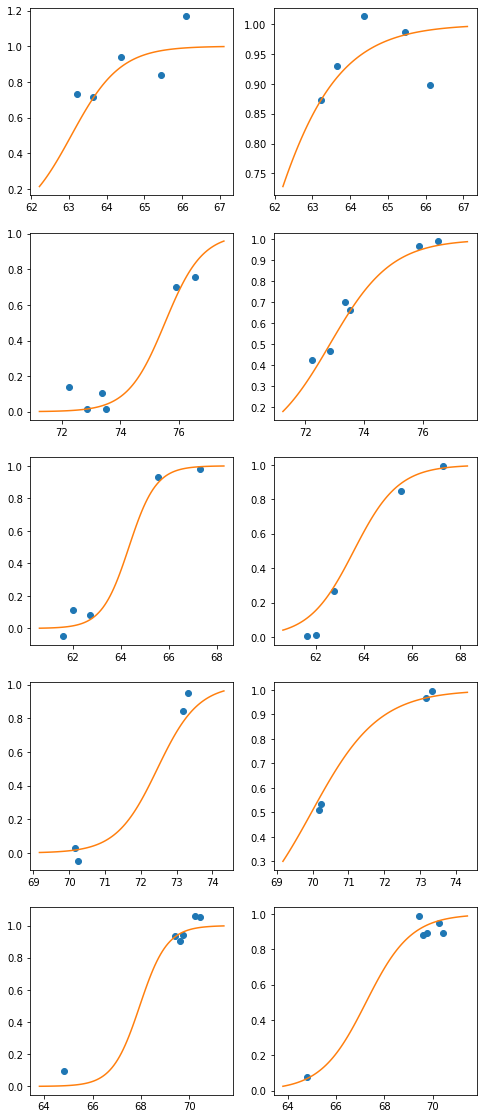

In [23]:
leaspy = Leaspy('linearB')
dimension = 2
sources_dimension = 1
leaspy.model.parameters = {'g': [0., 1.],
                           'v0':[.5, 0.],
                           'betas':[[1.]],
                           'tau_mean': 70., 'tau_std': 5.,
                           'xi_mean': 0., 'xi_std': .1,
                           'sources_mean': 0.,
                           'sources_std': 1.,
                           'noise_std': [.07]}
model1 = leaspy.model
model1.dimension = dimension
model1.source_dimension = sources_dimension
model1.parameters = {key: torch.tensor(val) for key, val in model1.parameters.items()}
model1.attributes = AttributesFactory.attributes(model1.name, dimension, sources_dimension)
model1.attributes._compute_positions(model1.parameters)
model1.attributes._compute_velocities(model1.parameters)
model1.attributes._compute_betas(model1.parameters)
model1.attributes._compute_orthonormal_basis()
model1.attributes._compute_mixing_matrix()
model1.is_initialized = True

periode = 15.
amplitude = 2.
model1.B = lambda x : 1./(1.+torch.exp(-x))

n_individuals = 100
nb_visits_min = 2
nb_visits_mean = 6
window = 2.

data, individuals = generate_data(model1, n_individuals, nb_visits_min, nb_visits_mean, window)

leaspy_data = Data.from_dataframe(data)

nb_ind_plot = 5

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(dimension * 4, nb_ind_plot * 4))

plot_generative(ax, individuals, model1, nb_ind_plot, dimension)
plt.show()


The standard deviation of the noise at the end of the calibration is:
0.1289

Calibration took: 5s

The standard deviation of the noise at the end of the personalization is:
0.1147

Personalization scipy_minimize took: 8s
/opt/anaconda3/envs/leaspy/lib/python3.7/site-packages/cvxpy/reductions/solvers/solving_chain.py:164: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)

The standard deviation of the noise at the end of the calibration is:
0.1109

Calibration took: 49s

The standard deviation of the noise at the end of the personalization is:
0.0993

Personalization scipy_minimize took: 14s
/opt/anaconda3/envs/leaspy/lib/python3.7/site-packages/cvxpy/reductions/solvers/solv

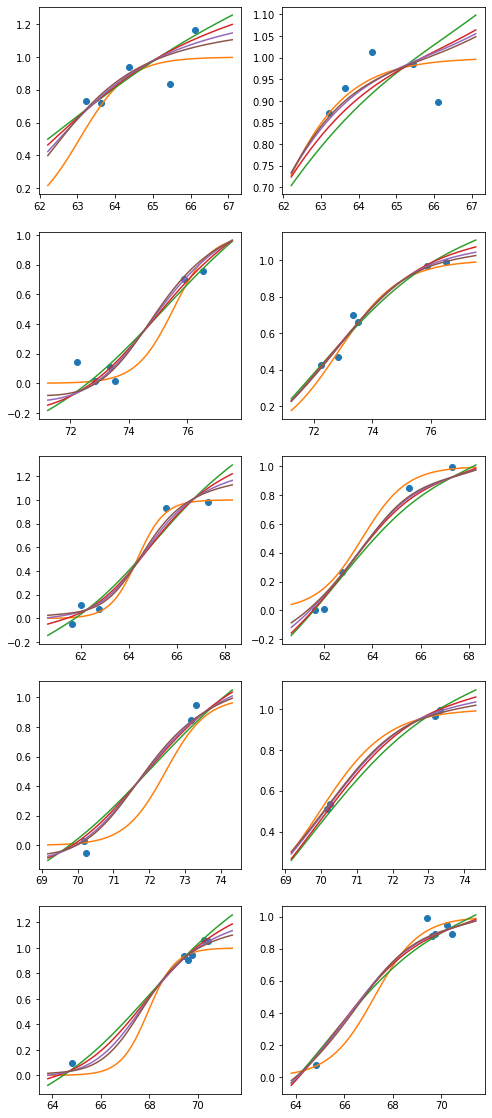

In [25]:
leaspy_test = Leaspy('linearB')

leaspy_test.model.load_hyperparameters({'source_dimension': 1}) # Optional
dataset = Dataset(leaspy_data)

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 1, 
                 "nb_control_points" : 10,"select":0.01}
meta_settings["fit"] = AlgorithmSettings('mcmc_saem', n_iter=1000, loss='MSE')
meta_settings["personalize"] = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_generative(ax, individuals, model1, nb_ind_plot, dimension)

for k in range(4):
    results = outer_iteration2(leaspy_test, leaspy_data, dataset, meta_settings)
    plot_fit(ax, results, leaspy_test.model, individuals, nb_ind_plot, dimension)
    
plt.show()

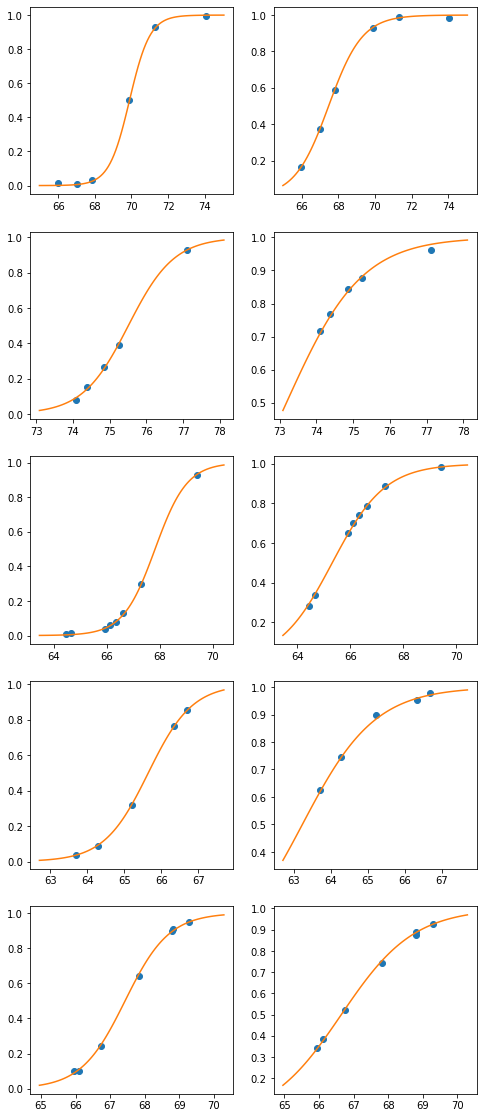

In [61]:
leaspy = Leaspy('linearB')
dimension = 2
sources_dimension = 1
leaspy.model.parameters = {'g': [0., 1.],
                           'v0':[.5, 0.],
                           'betas':[[1.]],
                           'tau_mean': 70., 'tau_std': 5.,
                           'xi_mean': 0., 'xi_std': .1,
                           'sources_mean': 0.,
                           'sources_std': 1.,
                           'noise_std': [.01]}
model1 = leaspy.model
model1.dimension = dimension
model1.source_dimension = sources_dimension
model1.parameters = {key: torch.tensor(val) for key, val in model1.parameters.items()}
model1.attributes = AttributesFactory.attributes(model1.name, dimension, sources_dimension)
model1.attributes._compute_positions(model1.parameters)
model1.attributes._compute_velocities(model1.parameters)
model1.attributes._compute_betas(model1.parameters)
model1.attributes._compute_orthonormal_basis()
model1.attributes._compute_mixing_matrix()
model1.is_initialized = True

periode = 15.
amplitude = 2.
model1.B = lambda x : 1./(1.+torch.exp(-x))

n_individuals = 100
nb_visits_min = 2
nb_visits_mean = 6
window = 2.

data, individuals = generate_data(model1, n_individuals, nb_visits_min, nb_visits_mean, window)

leaspy_data = Data.from_dataframe(data)

nb_ind_plot = 5

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(dimension * 4, nb_ind_plot * 4))

plot_generative(ax, individuals, model1, nb_ind_plot, dimension)
plt.show()


The standard deviation of the noise at the end of the calibration is:
0.1060

Calibration took: 5s

The standard deviation of the noise at the end of the personalization is:
0.0938

Personalization scipy_minimize took: 8s
/opt/anaconda3/envs/leaspy/lib/python3.7/site-packages/cvxpy/reductions/solvers/solving_chain.py:164: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)

The standard deviation of the noise at the end of the calibration is:
0.0885

Calibration took: 49s

The standard deviation of the noise at the end of the personalization is:
0.0777

Personalization scipy_minimize took: 14s
/opt/anaconda3/envs/leaspy/lib/python3.7/site-packages/cvxpy/reductions/solvers/solv

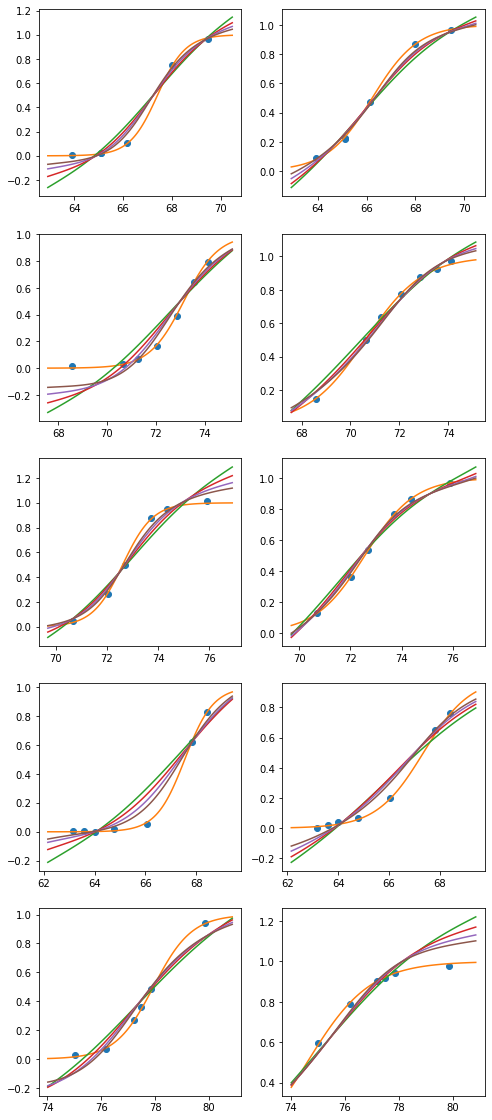

In [27]:
leaspy_test = Leaspy('linearB')

leaspy_test.model.load_hyperparameters({'source_dimension': 1}) # Optional
dataset = Dataset(leaspy_data)

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 1, 
                 "nb_control_points" : 10,"select":0.01}
meta_settings["fit"] = AlgorithmSettings('mcmc_saem', n_iter=1000, loss='MSE')
meta_settings["personalize"] = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_generative(ax, individuals, model1, nb_ind_plot, dimension)

for k in range(4):
    results = outer_iteration2(leaspy_test, leaspy_data, dataset, meta_settings)
    plot_fit(ax, results, leaspy_test.model, individuals, nb_ind_plot, dimension)
    
plt.show()


The standard deviation of the noise at the end of the calibration is:
0.1073

Calibration took: 5s

The standard deviation of the noise at the end of the personalization is:
0.0943

Personalization scipy_minimize took: 9s
1
2
4
temps opti quadra
0.02007999999977983
ipykernel_launcher:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
ipykernel_launcher:35: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead

The standard deviation of the noise at the end of the calibration is:
0.0915

Calibration took: 3min 13s

The standard deviation of the noise at the end of the personalization is:
0.0804

Personalization scipy_minimize took: 17s
1
temps opti quadra
0.004787000000305852
ipykernel_launcher:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from

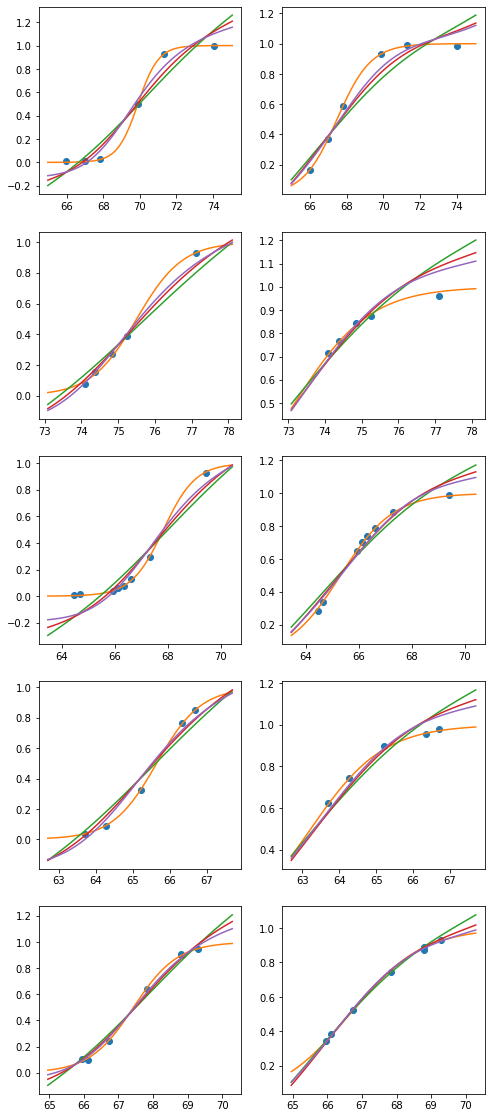

In [63]:
leaspy_test = Leaspy('linearB')

leaspy_test.model.load_hyperparameters({'source_dimension': 1}) # Optional
dataset = Dataset(leaspy_data)

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 1, 
                 "nb_control_points" : 50,"select":0.001}
meta_settings["fit"] = AlgorithmSettings('mcmc_saem', n_iter=1000, loss='MSE')
meta_settings["personalize"] = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_generative(ax, individuals, model1, nb_ind_plot, dimension)

for k in range(3):
    results = outer_iteration3(leaspy_test, leaspy_data, dataset, meta_settings)
    plot_fit(ax, results, leaspy_test.model, individuals, nb_ind_plot, dimension)
    
plt.show()


The standard deviation of the noise at the end of the calibration is:
0.1071

Calibration took: 5s

The standard deviation of the noise at the end of the personalization is:
0.0944

Personalization scipy_minimize took: 8s
1
2
temps opti quadra
0.015507999999954336
ipykernel_launcher:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
ipykernel_launcher:35: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead

The standard deviation of the noise at the end of the calibration is:
0.0876

Calibration took: 48s

The standard deviation of the noise at the end of the personalization is:
0.0777

Personalization scipy_minimize took: 16s
1
temps opti quadra
0.003477000000202679
ipykernel_launcher:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Pytho

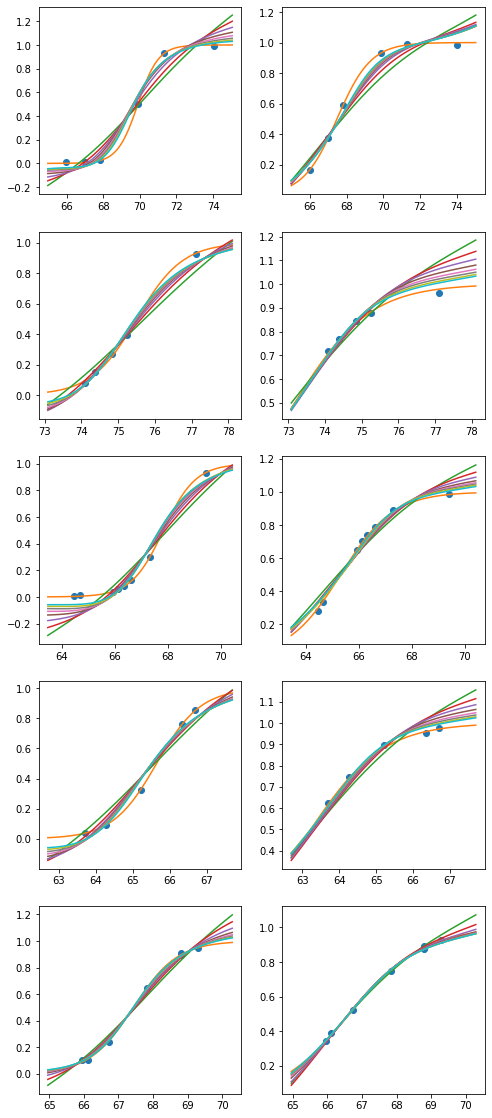

In [64]:
leaspy_test = Leaspy('linearB')

leaspy_test.model.load_hyperparameters({'source_dimension': 1}) # Optional
dataset = Dataset(leaspy_data)

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 1, 
                 "nb_control_points" : 10,"select":0.001}
meta_settings["fit"] = AlgorithmSettings('mcmc_saem', n_iter=1000, loss='MSE')
meta_settings["personalize"] = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_generative(ax, individuals, model1, nb_ind_plot, dimension)

for k in range(8):
    results = outer_iteration3(leaspy_test, leaspy_data, dataset, meta_settings)
    plot_fit(ax, results, leaspy_test.model, individuals, nb_ind_plot, dimension)
    
plt.show()

In [ ]:

‡